### Importing necessary libraries

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Defining the Stop Words 

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Importing the News Dataset 

In [4]:
df = pd.read_csv('news_dataset_jan.csv',index_col = 0)
df.shape

(3090, 4)

In [5]:
df = pd.read_csv('news_dataset_feb.csv',index_col = 0)
df.shape

(2874, 4)

In [6]:
df = pd.read_csv('news_dataset.csv',index_col = 0)
df.shape

(126, 4)

In [7]:
df.head()

,Date,Headline,Alternate Headline,Link
0,2020-12-07,\r\n\t\t\t\t\t \t\t\t\t\t Smaller towns drivin...,Network-backed OTTs see fast growth alongside ...,https://www.business-standard.com/article/comp...
1,2020-12-07,"\r\n\t\t\t\t\t \t\t\t\t\t Saraswat, Cosmos to ...",The two leading urban co-operative banks (UCBs...,https://www.business-standard.com/article/fina...
2,2020-12-07,\r\n\t\t\t\t\t \t\t\t\t\t Income mismatch prob...,The Central Board of Direct Taxes has directed...,https://www.business-standard.com/article/comp...
3,2020-12-07,\r\n\t\t\t\t\t \t\t\t\t\t Rahul Bhatia-owned I...,Thaw likely in IndiGo feud after EGM on Januar...,https://www.business-standard.com/article/comp...
4,2020-12-07,\r\n\t\t\t\t\t \t\t\t\t\t Shriram Capital's co...,"Its total income grew to Rs 5,407 crore in 201...",https://www.business-standard.com/article/comp...


In [8]:
# Convert to list
data = df.Headline.values.tolist()

### Remove Emails, new line characters and single quotes 

In [9]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

[' Smaller towns driving demand for regional content, OTT viewership growth ']


### Convert List of Sentences to List of List of Words 

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['smaller', 'towns', 'driving', 'demand', 'for', 'regional', 'content', 'ott', 'viewership', 'growth']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['smaller', 'towns', 'driving', 'demand', 'for', 'regional', 'content', 'ott', 'viewership', 'growth']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['small', 'town', 'drive', 'demand', 'regional', 'content', 'growth']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [15]:
id2word[0]

'content'

In [28]:
id2word

In [29]:
data_lemmatized

[['small', 'town', 'drive', 'demand', 'regional', 'content', 'growth'],
 ['approval', 'universal', 'banking', 'licence'],
 ['income', 'mismatch', 'probe', 'company'],
 ['own', 'may', 'back', 'rakesh', 'gangwal', 'exit', 'norm', 'relaxation'],
 ['consolidate', 'profit', 'tax', 'double', 'year'],
 ['small', 'unit', 'big', 'revisit', 'strategy', 'boost', 'revenue'],
 ['success', 'gain', 'currency', 'insolvency', 'resolution', 'professional'],
 ['have', 'strong', 'youtube', 'biz', 'eye'],
 ['pizza', 'ad', 'campaign'],
 ['see', 'sale', 'recover', 'fy', 'expect', 'growth'],
 ['set', 'sight', 'eye', 'mn', 'customer'],
 ['tell', 'story'],
 ['firm',
  'work',
  'vigorously',
  'invest',
  'heavily',
  'scale',
  'product',
  'business'],
 ['voda', 'idea', 'debt', 'follow', 'downgrade'],
 ['set', 'double', 'flight'],
 ['plan', 'increase', 'production'],
 ['banking', 'sector', 'stress', 'can', 'bail', 'say', 'abhijit', 'banerjee'],
 ['bad', 'loan', 'issue', 'expert', 'see', 'pain'],
 [],
 ['polit

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('content', 1),
  ('demand', 1),
  ('drive', 1),
  ('growth', 1),
  ('regional', 1),
  ('small', 1),
  ('town', 1)]]

# LDA - GENSIM

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"good" + 0.016*"issue" + 0.016*"see" + 0.016*"policy" + 0.014*"show" '
  '+ 0.014*"group" + 0.014*"expert" + 0.014*"loan" + 0.014*"shadow" + '
  '0.014*"bank"'),
 (1,
  '0.035*"share" + 0.025*"hit" + 0.022*"likely" + 0.020*"slip" + 0.017*"r" + '
  '0.017*"paper" + 0.017*"commercial" + 0.017*"volume" + 0.017*"trade" + '
  '0.007*"market"'),
 (2,
  '0.049*"budget" + 0.044*"firm" + 0.021*"boost" + 0.017*"may" + '
  '0.017*"challenge" + 0.015*"year" + 0.015*"young" + 0.015*"invest" + '
  '0.015*"term" + 0.015*"sector"'),
 (3,
  '0.036*"plan" + 0.019*"go" + 0.019*"chief" + 0.019*"day" + 0.017*"good" + '
  '0.016*"local" + 0.016*"consume" + 0.016*"ask" + 0.016*"selling" + '
  '0.016*"start"'),
 (4,
  '0.071*"say" + 0.018*"management" + 0.015*"land" + 0.015*"risk" + '
  '0.015*"link" + 0.015*"abhijit" + 0.015*"banerjee" + 0.015*"distribution" + '
  '0.014*"tax" + 0.013*"villager"')]


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.1717557176636655

Coherence Score:  0.49477645646377927


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\prash\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.039801 -0.147981       1        1  24.585754
4      0.111818  0.113808       2        1  20.582933
1      0.025660  0.003721       3        1  19.724264
3     -0.005007 -0.010077       4        1  17.849955
0     -0.172272  0.040529       5        1  17.257092, topic_info=    Category      Freq     Term     Total  loglift  logprob
80   Default  9.000000      say  9.000000  30.0000  30.0000
143  Default  8.000000   budget  8.000000  29.0000  29.0000
60   Default  7.000000     firm  7.000000  28.0000  28.0000
299  Default  4.000000    share  4.000000  27.0000  27.0000
74   Default  4.000000     plan  4.000000  26.0000  26.0000
..       ...       ...      ...       ...      ...      ...
422   Topic5  1.321228    brent  1.806340   1.4442  -4.3990
443   Topic5  1.321221  ranking  1.806334   1.4442  -4.3990
435   Topic5  2.468654     good  4.722775   1.1082  -3.7739
157   Topic5  1.541877     show  2.374756   1.3251  -4.2446
84    Topic5  1.541210   expert  2.640723   1.2185  -4.2450

[228 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
76        2  0.820335   abhijit
447       2  0.928043   acquire
196       4  0.861313     ahead
123       4  0.861315    arrest
439       4  0.899806       ask
...     ...       ...       ...
414       3  0.794033    volume
425       1  0.848985  wishlist
27        1  0.593405      year
27        3  0.296702      year
291       1  0.747743     young

[139 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

# LDA  -  MALLET (generally gives better topics)

In [17]:
from gensim.models.wrappers import LdaMallet
import os

### Defining the path of mallet and setting the environment variable of mallet

In [18]:
mallet_path = 'C:\\Users\\prash\\Downloads\\mallet-2.0.8\\bin\\mallet'

os.environ['MALLET_HOME'] = 'C:\\Users\\prash\\Downloads\\mallet-2.0.8\\'



### Creating the model

In [19]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=15, id2word=id2word)

### Show the created topics

In [27]:
result=(ldamallet.show_topics(num_topics=15,num_words=20,formatted=False))
pprint(result[0][1])

[('year', 0.029411764705882353),
 ('big', 0.029411764705882353),
 ('challenge', 0.022058823529411766),
 ('show', 0.022058823529411766),
 ('day', 0.014705882352941176)]


### Compute the Coherence Score

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet)

### Define a function to compute Coherence Values

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Compute the Coherence Values for different iterations

In [29]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

### Plot the obtained Coherence Values

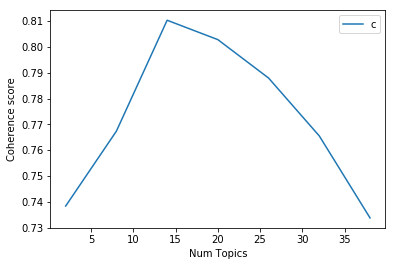

In [31]:
# Show graph
limit=40; start=2; step=6;

x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
model_list

NameError: name 'model_list' is not defined

### Print the Coherence Scores

In [37]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7383
Num Topics = 8  has Coherence Value of 0.7674
Num Topics = 14  has Coherence Value of 0.8103
Num Topics = 20  has Coherence Value of 0.8028
Num Topics = 26  has Coherence Value of 0.7879
Num Topics = 32  has Coherence Value of 0.7655
Num Topics = 38  has Coherence Value of 0.7337


### Select the Optimal Model and Print the topics generated from that model

In [22]:
optimal_model = model_list[3]

model_topics = optimal_model.show_topics(formatted=False)

pprint(optimal_model.print_topics(num_words=5))

NameError: name 'model_list' is not defined

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.0770,"budget, good, small, march, find, volume, prep...",Smaller towns driving demand for regional con...
1,1,15.0,0.0648,"banking, poor, rule, expect, charge, exchange,...","Saraswat, Cosmos to seek RBI approval for uni..."
2,2,9.0,0.0669,"plan, campaign, revenue, strategy, dot, shift,...","Income mismatch probe: 5,000 companies under ..."
3,3,7.0,0.0784,"challenge, entity, back, exit, abhijit, expans...",Rahul Bhatia-owned IGE may back Rakesh Gangwa...
4,4,5.0,0.0758,"stock, sector, double, order, holiday, boost, ...",Shriram Capitals consolidated profit after ta...
5,5,9.0,0.0750,"plan, campaign, revenue, strategy, dot, shift,...",Small units to be bigger as TCS revisits 2011...
6,6,6.0,0.0704,"day, resolution, part, big, boost, street, loc...",Success fee gaining currency among insolvency...
7,7,2.0,0.0648,"hit, eye, tax, norm, head, borrowing, party, l...","Weve strong YouTube biz; not eyeing Netflix, ..."
8,8,14.0,0.0639,"rise, slow, trigger, year, fine, business, boo...",Pizza Huts ad campaign is my favourite: Creat...
9,9,4.0,0.0778,"firm, sale, rise, resolution, increase, bail, ...",Alembic sees India sales recovering from Q1FY...


In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0823,"big, animal, group, case, rein, tighten, sugge...",Congress launches NUR campaign to gather deta...
1,1.0,0.0770,"budget, good, small, march, find, volume, prep...",Smaller towns driving demand for regional con...
2,2.0,0.0757,"hit, eye, tax, norm, head, borrowing, party, l...",Brookfield eyes co-living spaces; in talks wi...
3,3.0,0.0906,"expert, management, share, indian, demand, qui...",Dr Reddys posts Rs 570-cr net loss due to hea...
4,4.0,0.0916,"firm, sale, rise, resolution, increase, bail, ...",NCLT extends immunity to new board-appointed ...


In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"budget, good, small, march, find, volume, prep...",10.0,0.0794
1.0,15.0,"banking, poor, rule, expect, charge, exchange,...",10.0,0.0794
2.0,9.0,"plan, campaign, revenue, strategy, dot, shift,...",5.0,0.0397
3.0,7.0,"challenge, entity, back, exit, abhijit, expans...",12.0,0.0952
4.0,5.0,"stock, sector, double, order, holiday, boost, ...",5.0,0.0397
...,...,...,...,...
121.0,11.0,"caa, story, commercial, capital, india, foreig...",NaN,NaN
122.0,12.0,"boost, power, favour, improved, focus, pick, r...",NaN,NaN
123.0,12.0,"boost, power, favour, improved, focus, pick, r...",NaN,NaN
124.0,1.0,"budget, good, small, march, find, volume, prep...",NaN,NaN
